<a href="https://colab.research.google.com/github/sandrarajp/Retail-analysis-Dashboard/blob/main/retail_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np



In [2]:
df = pd.read_csv('sales_orders_synthetic.csv')

In [3]:
print(df.shape)
print(df.isnull().sum())
print(df.describe())


(600, 23)
OrderID         0
OrderDate       0
ShipDate        0
ShipMode        0
CustomerID      0
CustomerName    0
Segment         0
Country         0
State           0
City            0
PostalCode      0
SalesRepID      0
SalesRepName    0
ProductID       0
Category        0
Sub-Category    0
ProductName     0
UnitPrice       0
Quantity        0
Discount        0
Sales           0
Profit          0
Returned        0
dtype: int64
          PostalCode      UnitPrice    Quantity    Discount          Sales  \
count     600.000000     600.000000  600.000000  600.000000     600.000000   
mean   401932.101667   27992.644483    2.225000    0.054167   57338.238333   
std    161702.807024   33947.932659    1.350586    0.060252   88005.148804   
min    110560.000000      56.650000    1.000000    0.000000      79.180000   
25%    266510.000000    3788.415000    1.000000    0.000000    6750.537500   
50%    393189.000000   12755.225000    2.000000    0.050000   20134.995000   
75%    538928.250

In [4]:
df['OrderDate']=pd.to_datetime(df['OrderDate'])
df['ShipDate']=pd.to_datetime(df['ShipDate'])

In [7]:
df['DeliveryDays'] = (df['ShipDate']-df['OrderDate']).dt.days
df['Year'] = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.month
df['Quarter'] = df['OrderDate'].dt.quarter
df['ProfitMargin'] = df['Profit']/df['Sales']
df['ProfitMargin'] = df['ProfitMargin'].replace([np.inf,-np.inf],0).fillna(0)



In [8]:
monthly_trend = df.groupby(['Year','Month',])[['Sales','Profit']].sum().reset_index()
print(monthly_trend)

    Year  Month       Sales     Profit
0   2023      1  1288977.11  177743.14
1   2023      2  1937875.98  164068.13
2   2023      3  1168955.88  147670.79
3   2023      4  1435744.24  222470.88
4   2023      5  1078188.28  168508.66
5   2023      6  1162985.98   99236.05
6   2023      7  1606957.93  264732.91
7   2023      8   930200.13  131732.52
8   2023      9  1164077.10  138271.78
9   2023     10  1132241.77  156421.33
10  2023     11  1036844.35  130153.31
11  2023     12  1207378.29  151288.65
12  2024      1  1269897.10  152143.55
13  2024      2   916923.79  112230.63
14  2024      3  1454723.82  238624.94
15  2024      4  1010163.08  136689.79
16  2024      5   951645.79  120270.82
17  2024      6  1171787.23  179011.36
18  2024      7  1388773.56  200080.61
19  2024      8  1269199.53  155500.31
20  2024      9   958017.07  151253.68
21  2024     10   980254.60  124183.78
22  2024     11  1532787.17  176793.55
23  2024     12   546435.23   67875.91
24  2025      1   586544.

In [9]:
seg_cat = df.groupby(['Segment','Category'])[['Sales','Profit']].sum().reset_index()
print(seg_cat)

       Segment         Category        Sales      Profit
0     Consumer        Furniture   3119092.93   483703.33
1     Consumer  Office Supplies    589511.14   137542.43
2     Consumer       Technology  14756808.22  1699922.91
3    Corporate        Furniture   1120709.50   154815.35
4    Corporate  Office Supplies    250037.37    62914.02
5    Corporate       Technology   8478378.13  1108758.24
6  Home Office        Furniture   1217360.35   180251.66
7  Home Office  Office Supplies    335251.07    79805.12
8  Home Office       Technology   4535794.29   516590.87


In [10]:
top_sales = df.groupby('ProductName')['Sales'].sum().nlargest(15)
top_profit = df.groupby('ProductName')['Profit'].sum().nlargest(15)


In [11]:
return_rate = df.groupby(['Category','ShipMode'])['Returned'].mean().reset_index()


In [15]:
import pandas as pd
import numpy as np

# Assuming df is already loaded and has these columns:
# 'OrderDate', 'ShipDate', 'Profit', 'Sales', 'Returned', 'Category', 'State', 'ShipMode'

# --- Feature Engineering ---
df['DeliveryDays'] = (df['ShipDate'] - df['OrderDate']).dt.days
df['Year'] = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.month
df['Quarter'] = df['OrderDate'].dt.quarter
df['ProfitMargin'] = df['Profit'] / df['Sales']
df['ProfitMargin'] = df['ProfitMargin'].replace([np.inf, -np.inf], 0).fillna(0)

# --- 1. Best & Worst Profit Margin Category ---
category_margin = df.groupby('Category')['ProfitMargin'].mean().sort_values(ascending=False)
best_category = category_margin.index[0]
worst_category = category_margin.index[-1]

# --- 2. Return Rate by Delivery Speed Group ---
max_days = df['DeliveryDays'].max()
# Ensure bins are monotonic and meaningful
if pd.isna(max_days):
    bins = [0, 5, 10, 15]
    labels = ['0-5 days', '6-10 days', '10+ days']
elif max_days <= 5:
    bins = [0, max_days]
    labels = [f'0-{int(max_days)} days']
elif max_days <= 10:
    bins = [0, 5, max_days]
    labels = ['0-5 days', f'6-{int(max_days)} days']
else:
    bins = [0, 5, 10, max_days]
    labels = ['0-5 days', '6-10 days', '10+ days']

df['TenureGroup'] = pd.cut(df['DeliveryDays'], bins=bins, labels=labels, include_lowest=True)
return_rate_tenure = df.groupby('TenureGroup')['Returned'].mean()

# --- 3. Return Rate by State ---
state_returns = df.groupby('State')['Returned'].mean().sort_values(ascending=False)

# --- 4. Delivery Speed vs Returns Correlation ---
# Ensure both columns are numeric and no NaN for correlation
delivery_corr = df[['DeliveryDays', 'Returned']].dropna().corr().iloc[0, 1]

# --- 5. Profit Margin by Ship Mode ---
ship_margin = df.groupby('ShipMode')['ProfitMargin'].mean().sort_values(ascending=False)

# --- Print Insights ---
print(f"1. {best_category} category has the highest avg profit margin ({category_margin.max():.2%}), "
      f"while {worst_category} has the lowest ({category_margin.min():.2%}).")

if len(return_rate_tenure) > 1:
    print(f"2. Return rate by delivery group: {return_rate_tenure.to_dict()}")
else:
    print("2. Delivery days range too small to create multiple groups.")

print(f"3. Top 3 states with highest return rates: {state_returns.head(3).to_dict()}")

print(f"4. Correlation between delivery days and returns: {delivery_corr:.2f} "
      "(positive means longer delivery → more returns).")

print(f"5. Highest profit margin shipping mode: {ship_margin.index[0]} "
      f"({ship_margin.max():.2%}).")


1. Office Supplies category has the highest avg profit margin (23.62%), while Technology has the lowest (11.52%).
2. Return rate by delivery group: {'0-5 days': 0.06765327695560254, '6-8 days': 0.03937007874015748}
3. Top 3 states with highest return rates: {'Kerala': 0.12987012987012986, 'West Bengal': 0.08823529411764706, 'Tamil Nadu': 0.06153846153846154}
4. Correlation between delivery days and returns: -0.05 (positive means longer delivery → more returns).
5. Highest profit margin shipping mode: First Class (17.72%).


/tmp/ipython-input-724172766.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return_rate_tenure = df.groupby('TenureGroup')['Returned'].mean()


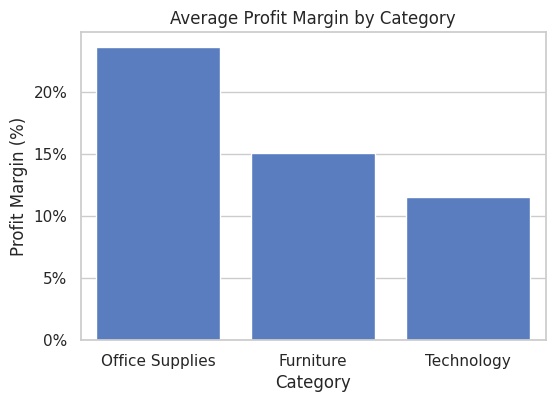

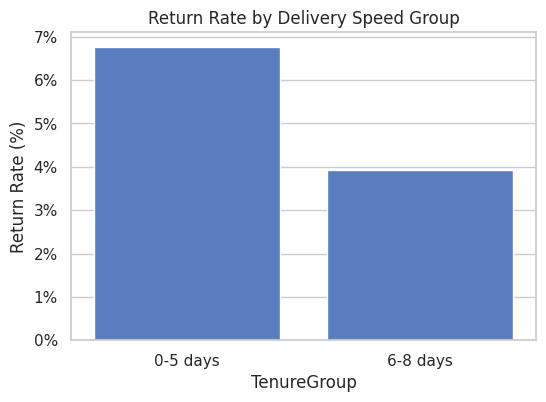

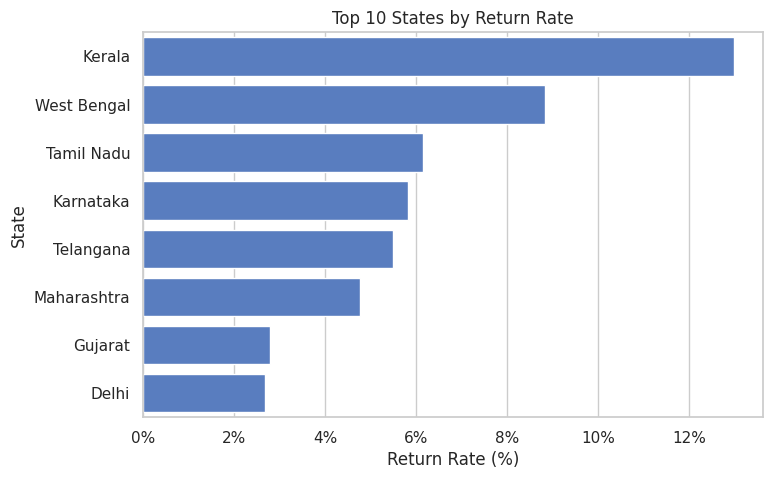

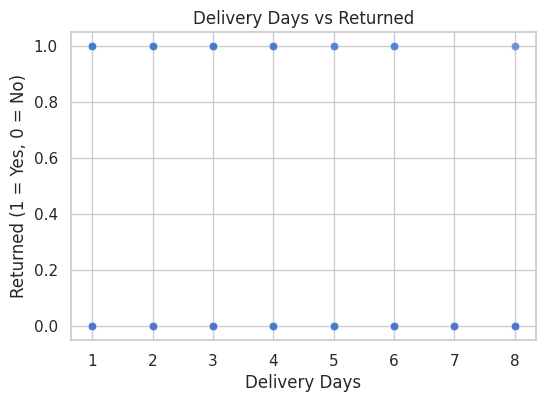

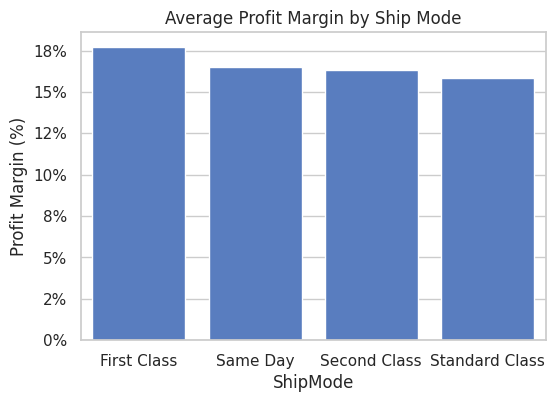

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply a clean style
sns.set(style="whitegrid", palette="muted")

# 1. Profit Margin by Category
plt.figure(figsize=(6,4))
sns.barplot(x=category_margin.index, y=category_margin.values)
plt.title("Average Profit Margin by Category")
plt.ylabel("Profit Margin (%)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()

# 2. Return Rate by Delivery Speed Group
if len(return_rate_tenure) > 0:
    plt.figure(figsize=(6,4))
    sns.barplot(x=return_rate_tenure.index.astype(str), y=return_rate_tenure.values)
    plt.title("Return Rate by Delivery Speed Group")
    plt.ylabel("Return Rate (%)")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.show()

# 3. Top 10 States by Return Rate
top_states = state_returns.head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_states.values, y=top_states.index)
plt.title("Top 10 States by Return Rate")
plt.xlabel("Return Rate (%)")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()

# 4. Delivery Days vs Return Rate (Scatter)
plt.figure(figsize=(6,4))
sns.scatterplot(x="DeliveryDays", y="Returned", data=df, alpha=0.5)
plt.title("Delivery Days vs Returned")
plt.xlabel("Delivery Days")
plt.ylabel("Returned (1 = Yes, 0 = No)")
plt.show()

# 5. Profit Margin by Ship Mode
plt.figure(figsize=(6,4))
sns.barplot(x=ship_margin.index, y=ship_margin.values)
plt.title("Average Profit Margin by Ship Mode")
plt.ylabel("Profit Margin (%)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()


/tmp/ipython-input-2534732910.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_margin.index, y=category_margin.values, ax=axes[0,0], palette=colors1)
/tmp/ipython-input-2534732910.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=return_rate_tenure.index.astype(str), y=return_rate_tenure.values, ax=axes[0,1], palette=colors2)
/tmp/ipython-input-2534732910.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, ax=axes[0,2], palette=colors3)
/tmp/ipython-input-2534732910.py:61: FutureW

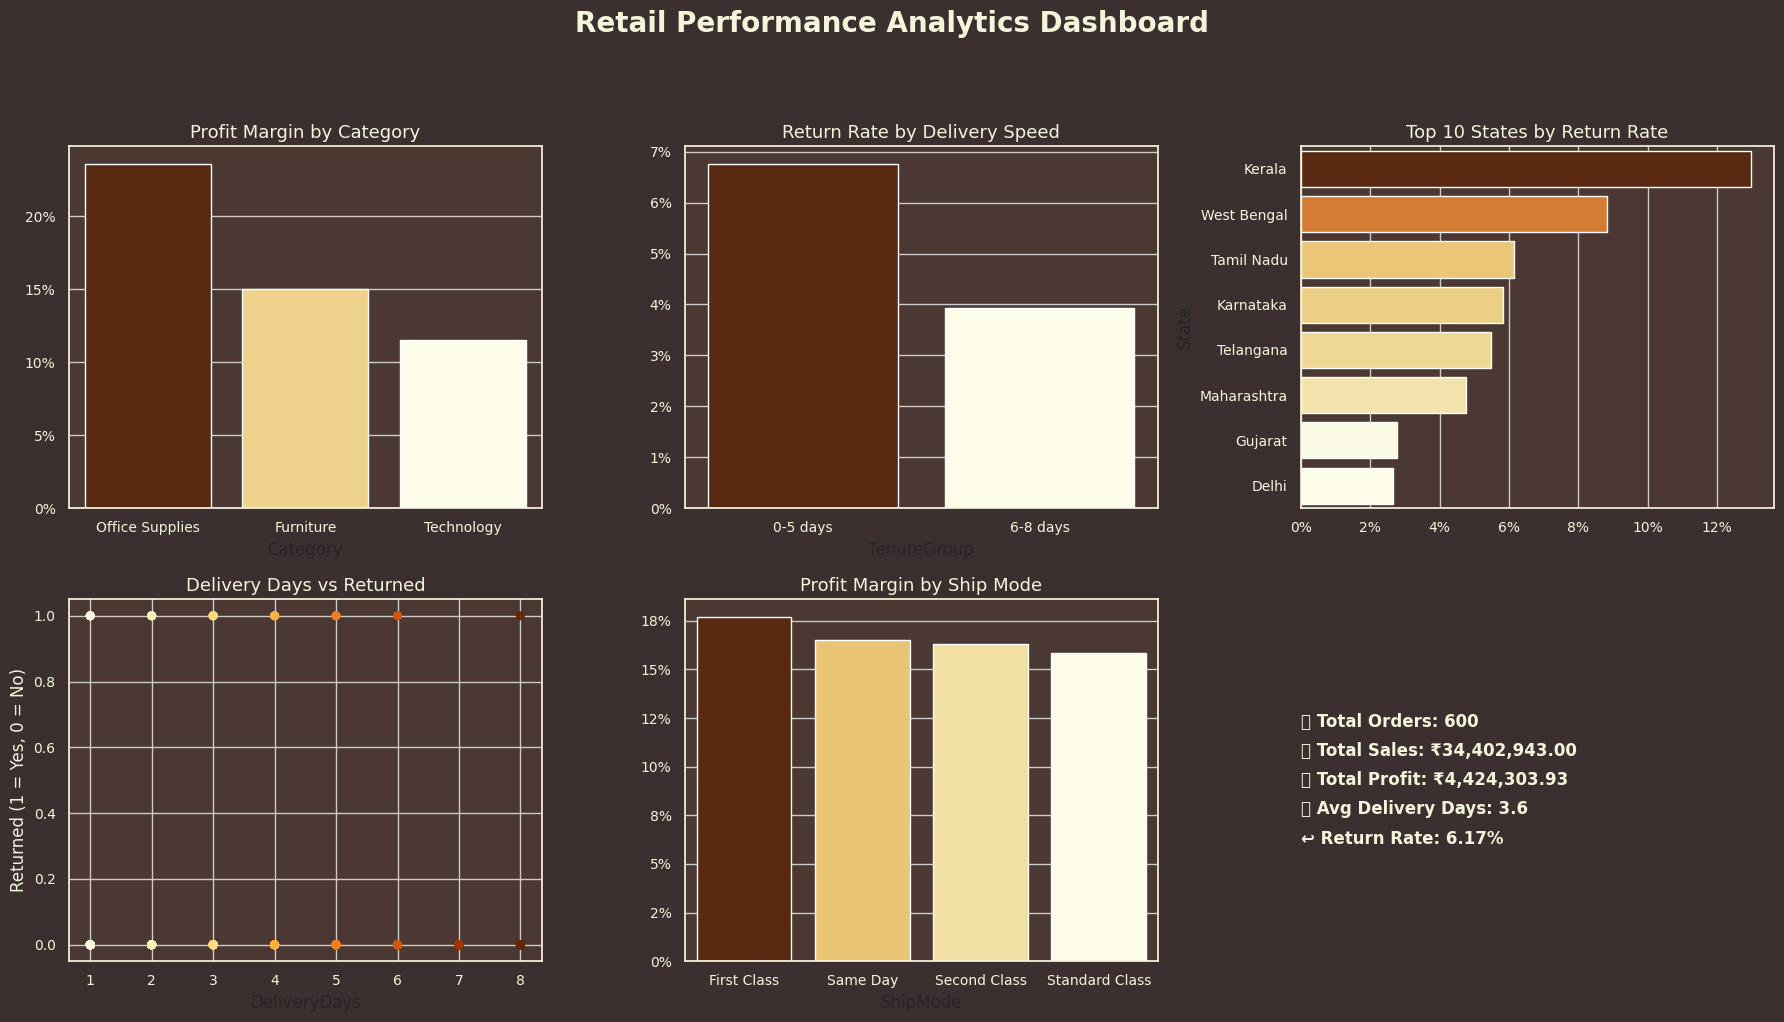

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np

# Coffee shop theme colors
dashboard_bg = "#3B2F2F"   # dark coffee brown
card_bg = "#4B3832"        # lighter coffee brown
text_color = "#F5F5DC"     # warm beige text
gradient_palette = "YlOrBr"

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.patch.set_facecolor(dashboard_bg)
fig.suptitle("Retail Performance Analytics Dashboard", fontsize=20, fontweight='bold', color=text_color, y=1.02)

# Apply background and text color to all subplots
for ax in axes.flat:
    ax.set_facecolor(card_bg)
    ax.tick_params(colors=text_color, labelsize=10)
    ax.title.set_color(text_color)
    for spine in ax.spines.values():
        spine.set_color(text_color)

# Function to generate gradient colors
def gradient_colors(values, palette):
    cmap = sns.color_palette(palette, as_cmap=True)
    norm = plt.Normalize(min(values), max(values))
    return [cmap(norm(v)) for v in values]

# 1. Profit Margin by Category
colors1 = gradient_colors(category_margin.values, gradient_palette)
sns.barplot(x=category_margin.index, y=category_margin.values, ax=axes[0,0], palette=colors1)
axes[0,0].set_title("Profit Margin by Category", fontsize=13)
axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

# 2. Return Rate by Delivery Speed
if len(return_rate_tenure) > 0:
    colors2 = gradient_colors(return_rate_tenure.values, gradient_palette)
    sns.barplot(x=return_rate_tenure.index.astype(str), y=return_rate_tenure.values, ax=axes[0,1], palette=colors2)
    axes[0,1].set_title("Return Rate by Delivery Speed", fontsize=13)
    axes[0,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
else:
    axes[0,1].text(0.5, 0.5, "No Delivery Groups", ha='center', va='center', color=text_color, fontsize=12)
    axes[0,1].set_title("Return Rate by Delivery Speed", fontsize=13)

# 3. Top 10 States by Return Rate
top_states = state_returns.head(10)
colors3 = gradient_colors(top_states.values, gradient_palette)
sns.barplot(x=top_states.values, y=top_states.index, ax=axes[0,2], palette=colors3)
axes[0,2].set_title("Top 10 States by Return Rate", fontsize=13)
axes[0,2].xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

# 4. Delivery Days vs Returned
sns.scatterplot(x="DeliveryDays", y="Returned", data=df, ax=axes[1,0], hue="DeliveryDays", palette=gradient_palette, alpha=0.7, edgecolor=None, legend=False)
axes[1,0].set_title("Delivery Days vs Returned", fontsize=13)
axes[1,0].set_ylabel("Returned (1 = Yes, 0 = No)", color=text_color)

# 5. Profit Margin by Ship Mode
colors5 = gradient_colors(ship_margin.values, gradient_palette)
sns.barplot(x=ship_margin.index, y=ship_margin.values, ax=axes[1,1], palette=colors5)
axes[1,1].set_title("Profit Margin by Ship Mode", fontsize=13)
axes[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

# 6. KPI Summary Card
axes[1,2].axis('off')
kpi_text = (
    f"📦 Total Orders: {len(df):,}\n"
    f"💰 Total Sales: ₹{df['Sales'].sum():,.2f}\n"
    f"💹 Total Profit: ₹{df['Profit'].sum():,.2f}\n"
    f"⏱ Avg Delivery Days: {df['DeliveryDays'].mean():.1f}\n"
    f"↩ Return Rate: {df['Returned'].mean():.2%}"
)
axes[1,2].text(0, 0.5, kpi_text, fontsize=12, va='center', fontweight='bold', color=text_color, linespacing=1.8)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
